# Milestone 2

---

Milestones ini dibuat guna mengevaluasi pembelajaran pada Hacktiv8 Data Science Full Time Program Phase 2 khususnya pada Deep Learning.

## Introduction

By [Rifky Aliffa](https://github.com/Penzragon)

![Image](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg/1200px-The_Rim_Fire_in_the_Stanislaus_National_Forest_near_in_California_began_on_Aug._17%2C_2013-0004.jpg)

### Dataset

Pada project ini dataset yang digunakan adalah berbagai macam gambar kebakaran dan api. Dataset dapat dilihat di [Kaggle](https://www.kaggle.com/datasets/phylake1337/fire-dataset).

### Objectives

**Milestones 2** ini dibuat guna mengevaluasi Pembelajaran Phase 2 :

- Mampu memahami konsep Computer Vision/NLP.
- Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
- Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
- Mampu menganalisis dan menjelaskan layer yang dibuat.

Dan tujuan utama dari project ini adalah untuk membuat model CNN yang mampu mendeteksi **kebakaran hutan**.

## Import Libraries

Pada project ini library utama yang digunakan adalah **Pandas**, **NumPy**, **Matplotlib**, **Seaborn**, **Scikit-Learn**, **Tensorflow**, dan **Keras**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from PIL import Image
from io import BytesIO

Melakukan konfigurasi untuk mengizinkan tensorflow menggunakan memory GPU.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Data Loading

Pada bagian ini data gambar akan di load menggunakan `ImageDataGenerator`.

In [3]:
# Training data path
train_dir = 'dataset/fire_dataset/train/'

# Validation data path
test_dir = 'dataset/fire_dataset/test/'

In [4]:
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, width_shift_range=0.4, height_shift_range=0.4, shear_range=0.4, zoom_range=0.4)
valid_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=23, class_mode='binary')
valid_data = valid_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=23, class_mode='binary')

Found 1169 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


Terdapat **1169** file gambar pada training set dan **292** file gambar pada validation set.

## Exploratory Data Analysis

Pada bagian data exploration ini akan dilakukan sedikit eksplorasi pada dataset gambar yang digunakan.

In [5]:
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f'Found {len(dirnames)} folders with {len(filenames)} images in {dirpath}')

Found 2 folders with 0 images in dataset/fire_dataset/train/
Found 0 folders with 604 images in dataset/fire_dataset/train/fire
Found 0 folders with 565 images in dataset/fire_dataset/train/non_fire


Pada folder `train/` terdapat **1169** file gambar, dimana:
- **604** file gambar kebakaran
- **565** file gambar bukan kebakaran

In [6]:
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f'Found {len(dirnames)} folders with {len(filenames)} images in {dirpath}')

Found 2 folders with 0 images in dataset/fire_dataset/test/
Found 0 folders with 151 images in dataset/fire_dataset/test/fire
Found 0 folders with 141 images in dataset/fire_dataset/test/non_fire


Pada folder `test/` terdapat **292** file gambar, dimana:
- **151** file gambar kabakaran
- **141** file gambar bukan kebakaran

### Fire Image Samples

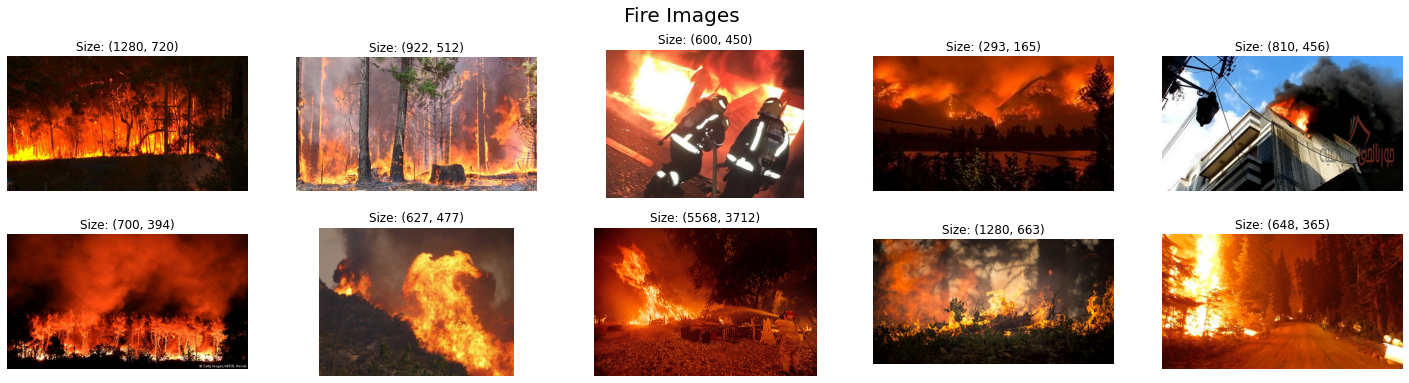

In [79]:
plt.figure(figsize=(25, 6))
plt.suptitle('Fire Images', fontsize=20)
for i in range(10):
    plt.subplot(2, 5, i+1)
    random_img = random.sample(os.listdir(train_dir + 'fire/'), 1)
    img = image.load_img(train_dir + 'fire/' + random_img[0])
    plt.imshow(img)
    plt.title(f'Size: {img.size}')
    plt.axis('off')
plt.show()

Gambar-gambar diatas merupakan sample dari gambar kebakaran yang berada pada training set. Dapat dilihat setiap gambar memiliki ukuran **pixel yang berbeda-beda** dan jika dilihat kebanyakan dari gambar kebarakan didominasi oleh warna **merah** dan **orange**, gambar-gambar kebakaran ini juga cederung gambar yang gelap.

### Non Fire Image Samples

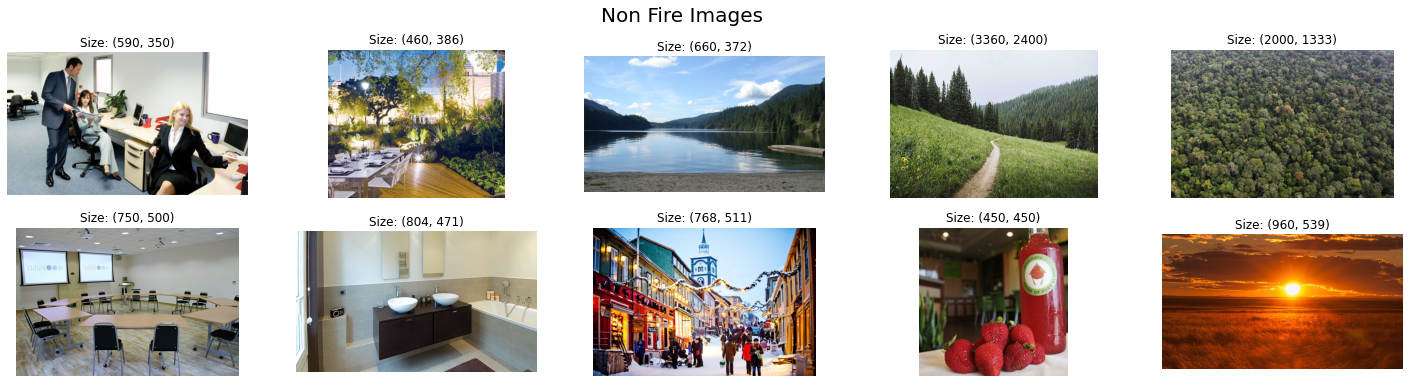

In [77]:
plt.figure(figsize=(25, 6))
plt.suptitle('Non Fire Images', fontsize=20)
for i in range(10):
    plt.subplot(2, 5, i+1)
    random_img = random.sample(os.listdir(train_dir + 'non_fire/'), 1)
    img = image.load_img(train_dir + 'non_fire/' + random_img[0])
    plt.imshow(img)
    plt.title(f'Size: {img.size}')
    plt.axis('off')
plt.show()

Sama seperti gambar kebakaran, gambar-gambar yang bukan kebakaran ini memiliki ukuran pixel yang berbeda-beda namun tidak seperti gambar kebakaran, gambar bukan kebakaran ini memiliki gambar yang lebih cerah dan didominasi oleh warna **hijau** dan **biru**.

## Data Preprocessing

Saat melakukan pengambilan data gambar dari direktori pada bagian **Data Loading**, data sudah dilakukan preprocessing dengan menggunakan:
- `rescale` = 1./255
- `horizontal_flip` = True
- `vertical_flip` = True
- `rotation_range` = 90
- `width_shift_range` = 0.4
- `height_shift_range` =  0.4
- `shear_range` = 0.4
- `zoom_range` = 0.4

Proeses data preprocessing di atas dilakukan pada training setnya saja untuk menghindari overfitting pada model, sedangkan untuk validation setnya hanya dilakukan rescaling.

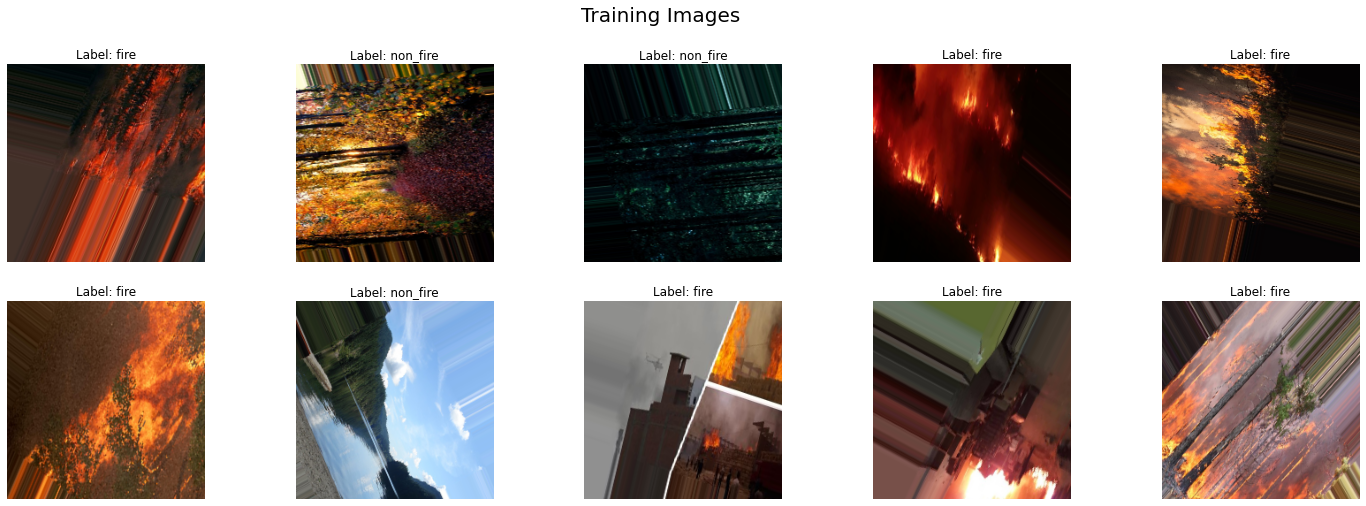

In [73]:
plt.figure(figsize=(25, 8))
plt.suptitle('Training Images', fontsize=20)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i][0][0])
    plt.title(f'Label: {"fire" if int(train_data[i][1][0]) == 0 else "non_fire"}')
    plt.axis('off')
plt.show()

Gambar-gambar di atas merupakan data training set yang telah melalui proses preprocessing, dapat dilihat gambar ini sudah memiliki ukuran pixel yang sama yaitu 224x224 pixel. Gambar juga sudah berubah bentuk ada yang dirotasi, dizoom, digeser, dan sebagainya.

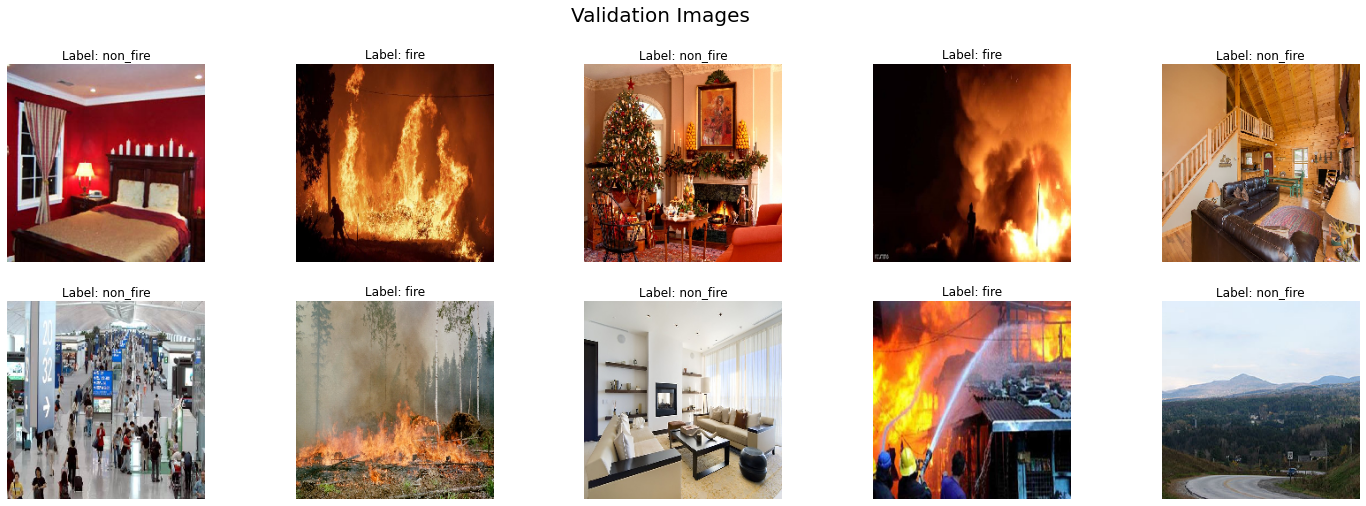

In [74]:
plt.figure(figsize=(25, 8))
plt.suptitle('Validation Images', fontsize=20)
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(valid_data[i][0][0])
    plt.title(f'Label: {"fire" if int(valid_data[i][1][0]) == 0 else "non_fire"}')
    plt.axis('off')
plt.show()

Sedangakan untuk gambar-gambar pada validation set diatas, jika dilihat tidak ada gambar yang diputar, digeser, ataupun dizoom ini karena pada validation set hanya dilakukan proses rescaling dan resizing saja.

## Model Definition

In [ ]:
tf.keras.backend.clear_session()

In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 16)                2

## Model Training

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=25, validation_data=valid_data)

Epoch 1/25
51/51 [==============================] - 37s 611ms/step - loss: 0.5647 - accuracy: 0.7656 - val_loss: 0.7763 - val_accuracy: 0.7568
Epoch 2/25
51/51 [==============================] - 29s 575ms/step - loss: 0.3794 - accuracy: 0.8512 - val_loss: 0.5457 - val_accuracy: 0.7637
Epoch 3/25
51/51 [==============================] - 29s 572ms/step - loss: 0.3683 - accuracy: 0.8392 - val_loss: 0.5448 - val_accuracy: 0.7705
Epoch 4/25
51/51 [==============================] - 30s 585ms/step - loss: 0.3392 - accuracy: 0.8580 - val_loss: 0.5255 - val_accuracy: 0.7877
Epoch 5/25
51/51 [==============================] - 30s 588ms/step - loss: 0.3546 - accuracy: 0.8589 - val_loss: 0.6488 - val_accuracy: 0.7637
Epoch 6/25
51/51 [==============================] - 31s 609ms/step - loss: 0.3284 - accuracy: 0.8631 - val_loss: 0.4616 - val_accuracy: 0.8116
Epoch 7/25
51/51 [==============================] - 30s 583ms/step - loss: 0.3326 - accuracy: 0.8571 - val_loss: 0.4524 - val_accuracy: 0.7911

## Model Evaluation

In [13]:
metrics = pd.DataFrame(history.history)
metrics.tail()

loss  accuracy  val_loss  val_accuracy
20  0.245343  0.894782  0.483980      0.763699
21  0.245187  0.905047  0.476702      0.818493
22  0.277001  0.892216  0.451607      0.770548
23  0.257330  0.897348  0.527367      0.784247
24  0.248362  0.905903  0.368398      0.835616

In [17]:
print('-----------Training Results-----------')
train_results = model.evaluate(train_data, verbose=0)
print(f'Training Loss       : {train_results[0]:.4f}')
print(f'Training Accuracy   : {train_results[1]:.4f}')

print('-----------Validation Results-----------')
validation_results = model.evaluate(valid_data, verbose=0)
print(f'Validation Loss     : {validation_results[0]:.4f}')
print(f'Validation Accuracy : {validation_results[1]:.4f}')

-----------Training Results-----------
Training Loss       : 0.2314
Training Accuracy   : 0.9025
-----------Validation Results-----------
Validation Loss     : 0.3684
Validation Accuracy : 0.8356


### Loss and Accuracy Curves

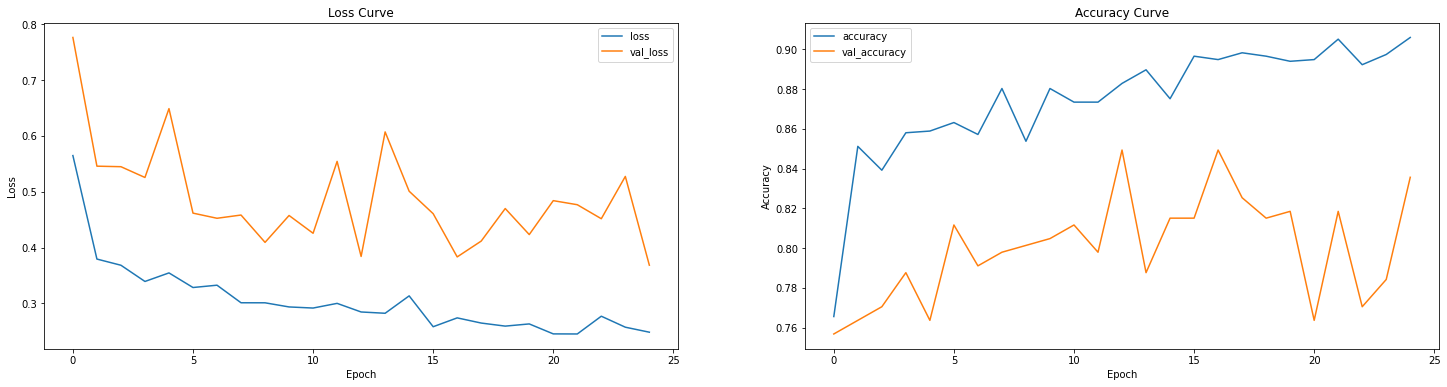

In [14]:
metrics = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(25, 6))
metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss Curve', xlabel='Epoch', ylabel='Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
plt.show()

### Confusion Matrix

In [15]:
y_pred_train = tf.round(model.predict(train_data))
y_pred_test = tf.round(model.predict(valid_data))
y_train = train_data.classes
y_test = valid_data.classes

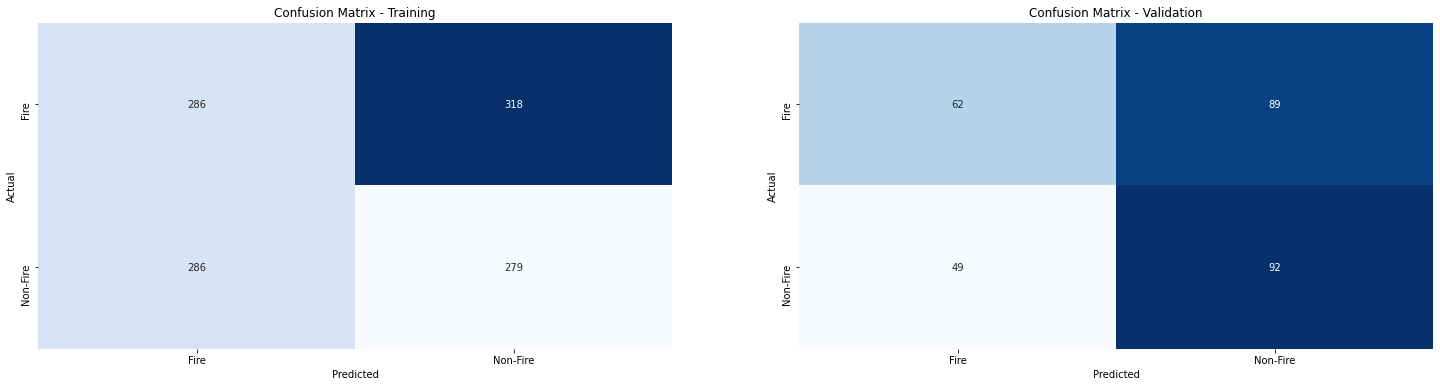

In [16]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Training')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
fig = sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Validation')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model Analysis

## Model Improvement

In [18]:
tf.keras.backend.clear_session()

In [19]:
# Load pretrained model
pretrained_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
pretrained_model.trainable = False

In [20]:
# Create the model
model2 = Sequential()
model2.add(pretrained_model)
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [21]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 21,132,073
Trainable params: 270,593
Non-trainable params: 20,861,480
_________________________________________________________________


In [22]:
# Compile the model
model2.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_data, epochs=25, validation_data=train_data, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Epoch 1/25
51/51 [==============================] - 65s 1s/step - loss: 0.3807 - accuracy: 0.8332 - val_loss: 0.2500 - val_accuracy: 0.9025
Epoch 2/25
51/51 [==============================] - 56s 1s/step - loss: 0.2525 - accuracy: 0.9033 - val_loss: 0.2125 - val_accuracy: 0.9204
Epoch 3/25
51/51 [==============================] - 60s 1s/step - loss: 0.2015 - accuracy: 0.9247 - val_loss: 0.1922 - val_accuracy: 0.9307
Epoch 4/25
51/51 [==============================] - 58s 1s/step - loss: 0.1988 - accuracy: 0.9204 - val_loss: 0.1708 - val_accuracy: 0.9376
Epoch 5/25
51/51 [==============================] - 57s 1s/step - loss: 0.1731 - accuracy: 0.9358 - val_loss: 0.1697 - val_accuracy: 0.9427
Epoch 6/25
51/51 [==============================] - 57s 1s/step - loss: 0.1743 - accuracy: 0.9341 - val_loss: 0.1973 - val_accuracy: 0.9281
Epoch 7/25
51/51 [==============================] - 56s 1s/step - loss: 0.2017 - accuracy: 0.9299 - val_loss: 0.1845 - val_accuracy: 0.9273
Epoch 8/25
51/51 [==

In [23]:
print('-----------Training Results-----------')
train_results = model2.evaluate(train_data, verbose=0)
print(f'Training Loss       : {train_results[0]:.4f}')
print(f'Training Accuracy   : {train_results[1]:.4f}')

print('-----------Validation Results-----------')
validation_results = model2.evaluate(valid_data, verbose=0)
print(f'Validation Loss     : {validation_results[0]:.4f}')
print(f'Validation Accuracy : {validation_results[1]:.4f}')

-----------Training Results-----------
Training Loss       : 0.1859
Training Accuracy   : 0.9316
-----------Validation Results-----------
Validation Loss     : 0.1560
Validation Accuracy : 0.9486


### Loss and Accuracy Curves

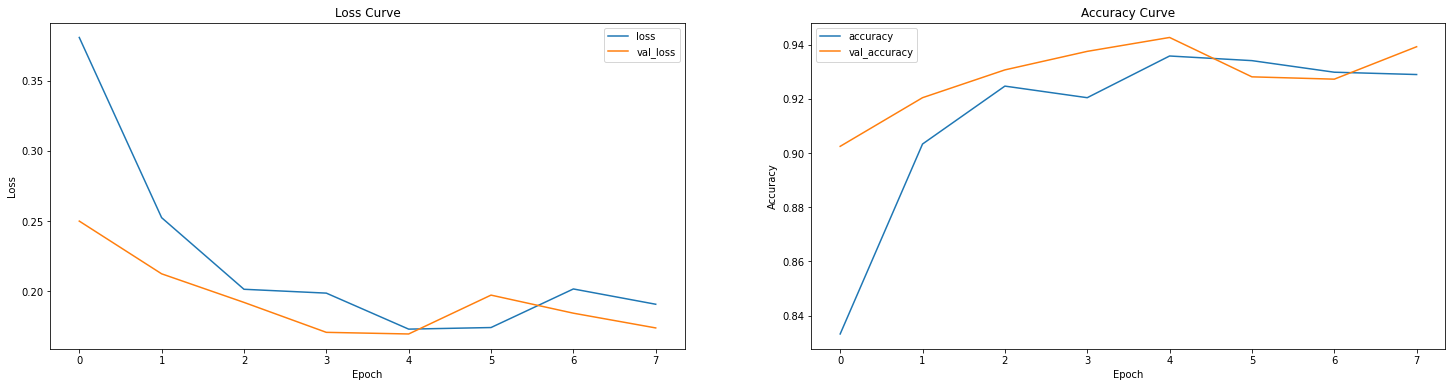

In [24]:
metrics = pd.DataFrame(history2.history)

fig, ax = plt.subplots(1, 2, figsize=(25, 6))
metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss Curve', xlabel='Epoch', ylabel='Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
plt.show()

### Confusion Matrix

In [25]:
y_pred_train = tf.round(model2.predict(train_data))
y_pred_test = tf.round(model2.predict(valid_data))
y_train = train_data.classes
y_test = valid_data.classes

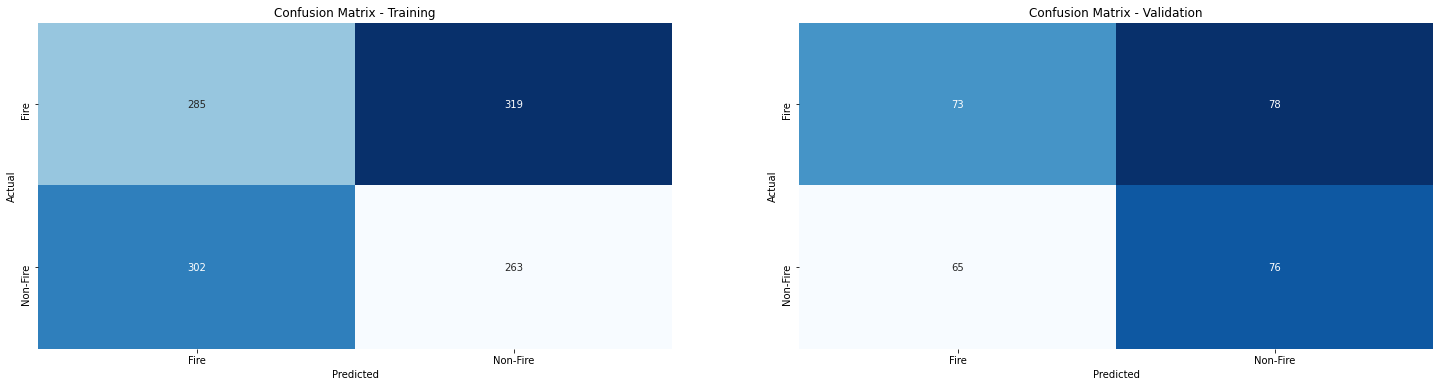

In [26]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Training')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
fig = sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Validation')
fig.set_xticklabels(['Fire', 'Non-Fire'])
fig.set_yticklabels(['Fire', 'Non-Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model Analysis

## Model Saving

## Model Testing

### From Local Storage

In [32]:
def load_img(filename, img_shape=224):
  img = read_file(filename)
  img = decode_image(img, channels=3)
  img = resize(img, size=[img_shape, img_shape])
  img = img/255.
  return img

In [33]:
img1 = load_img('img1.jpg')
img2 = load_img('img2.jpg')
img3 = load_img('img3.jpg')
img4 = load_img('img4.jpg')
img5 = load_img('img5.jpg')

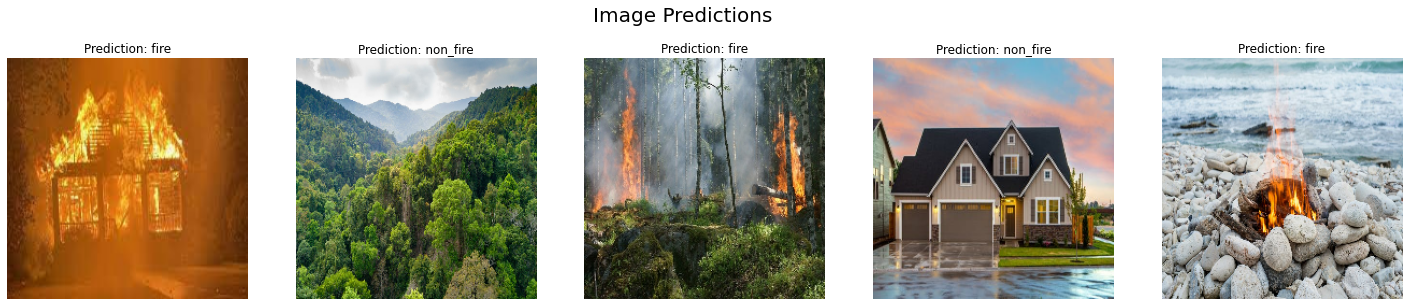

In [39]:
plt.figure(figsize=(25, 5))
plt.suptitle('Image Predictions', fontsize=20)
counter = 1
for i in [img1, img2, img3, img4, img5]:
    plt.subplot(1, 5, counter)
    res = int(tf.round(model2.predict(x=expand_dims(i, axis=0))))
    plt.imshow(i)
    plt.title(f"Prediction: {'fire' if res == 0 else 'non_fire'}")
    plt.axis('off')
    counter += 1
plt.show()  

### From URL

In [49]:
url = [
       "https://swaddle-wkwcb6s.stackpathdns.com/wp-content/uploads/2019/08/Amozon-forest-fire-Web-1-760x500.jpg",
       'https://miro.medium.com/max/1400/1*IC7_pdLtDMqwoqLkTib4JQ.jpeg',
       'https://www.globaltimes.cn/Portals/0/attachment/2021/2021-08-02/a93da530-4a35-4ff9-8af1-786ac98b5787.jpeg',
       'https://blogs.worldbank.org/sites/default/files/endpovertyinsouthasia/in-forestfires-shutter.jpg',
       'https://learnenglishteens.britishcouncil.org/sites/teens/files/styles/article/public/field/image/rs930_135120665-low.jpg?itok=g5LI5W4C'
       ]

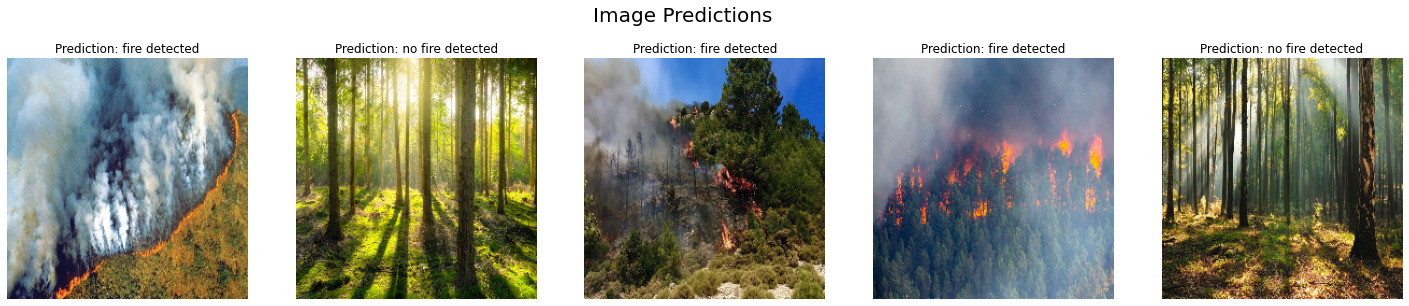

In [50]:
plt.figure(figsize=(25, 5))
plt.suptitle('Image Predictions', fontsize=20)
for i in range(len(url)):
    response = requests.get(url[i])
    img = Image.open(BytesIO(response.content))
    img = np.array(img)
    img = resize(img, size=[224, 224])
    img = img/255.
    plt.subplot(1, len(url), i+1)
    plt.imshow(img)
    res = int(tf.round(model2.predict(x=expand_dims(img, axis=0))))
    plt.title(f"Prediction: {'fire detected' if res == 0 else 'no fire detected'}")
    plt.axis('off')
plt.show()

## Conclusion